## Problem statement 

##### To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

#### Approach to build model:

1. Build a basic model, without any tuning
2. Apply Aumentation techniques on the images and check if the results improve
3. Techniques like drop out, if any sign of overfitting
4. Handle class-imbalance, and once again build model

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import random
from skimage import io
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D

### Importing Skin Cancer Data

In [2]:
## Mounting google drive for running the notebook on Google Colab

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("gdrive/MyDrive/Project/Train")
data_dir_test = pathlib.Path("gdrive/MyDrive/Project/Test")


In [4]:
#Counting the number of images in train and test folders

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

We will use 80% of the images for training, and 20% for validation.

In [6]:
#Creating train dataset
#Using seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
#Resizing the images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset="training",
    interpolation='bilinear', follow_links=False)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
#Creating validation dataset
#Using seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
#Resizing the images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset="validation",
    interpolation='bilinear', follow_links=False)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
#Listing out all the classes of skin cancer and store them in a list. 

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Lets visualize one instance of all the nine classes present in the dataset

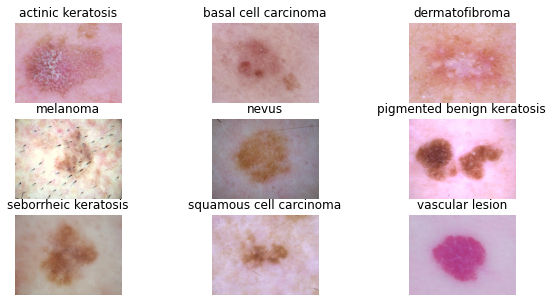

In [9]:
#Using matplot for visualization with 3*3 grid plot
#We will glob through each subfolder(class) and randomly pick an image from it

fig = plt.figure(figsize=(10,5))
i=0
for classes in class_names:
    images_path = os.path.join(data_dir_train, classes, '*')
    ax = plt.subplot(3, 3, i+1)
    i=i+1
# glob through the directory (returns a list of all file paths)
    images_path = glob.glob(images_path)
    rand_index = random.randint(0, len(images_path))
    image = io.imread(images_path[rand_index])
    plt.imshow(image)
    plt.title(classes)
    plt.axis("off")

In [10]:
#Checking the shape of the datset created
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating the first model
#### Lets create a CNN model, which can accurately detect 9 classes present in the dataset. We will be using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### standardizing the pixel values between (0,1) 

#defining normalization_layer
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

#applying normalization layer to the datset using map
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

# lets check the minimum and the maximum pixels values for the first image, if they are within `[0,1]`
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.27973858 0.86666745


In [13]:
#Checking the shape of the normalized datset
for image_batch, labels_batch in normalized_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [14]:
#Defining the architecture of the model

num_classes = 9

model = tf.keras.Sequential([
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes),
  layers.Activation('softmax')
])

### Compile the model
Choose an appropirate optimizer and loss function for model training.

Optimizer: We are going to use 'adam'. It stands for Adaptive Moment Estimation, it combines the power of RMSProp (root-mean-square prop) and momentum-based GD. 

Loss function: 'sparse_categorical_crossentropy'. It is similar to categorical_crossentropy, instead of one-hot-encoded vector, it works on integer. This gives an advantage that it saves time in memory as well as computation because it simply uses a single integer for a class, rather than a whole vector.

In [15]:
### Lets choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model

In [16]:
#Training the model for 20 epochs

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


56/56 [==============================] - 92s 1s/step - loss: 16.7069 - accuracy: 0.2143 - val_loss: 2.1689 - val_accuracy: 0.1879
Epoch 2/20
56/56 [==============================] - 2s 35ms/step - loss: 2.0693 - accuracy: 0.2489 - val_loss: 2.0081 - val_accuracy: 0.2796
Epoch 3/20
56/56 [==============================] - 2s 35ms/step - loss: 2.0683 - accuracy: 0.2377 - val_loss: 2.0724 - val_accuracy: 0.2215
Epoch 4/20
56/56 [==============================] - 2s 34ms/step - loss: 2.0060 - accuracy: 0.2422 - val_loss: 2.0185 - val_accuracy: 0.2483
Epoch 5/20
56/56 [==============================] - 2s 35ms/step - loss: 1.9635 - accuracy: 0.2640 - val_loss: 1.9787 - val_accuracy: 0.2729
Epoch 6/20
56/56 [==============================] - 2s 35ms/step - loss: 1.9964 - accuracy: 0.2623 - val_loss: 2.0425 - val_accuracy: 0.2215
Epoch 7/20
56/56 [==============================] - 2s 34ms/step - loss: 1.9213 - accuracy: 0.2628 - val_loss: 2.1727 - val_accuracy: 0.2371
Epoch 8/20
56/56 [======

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0

### Visualizing training results

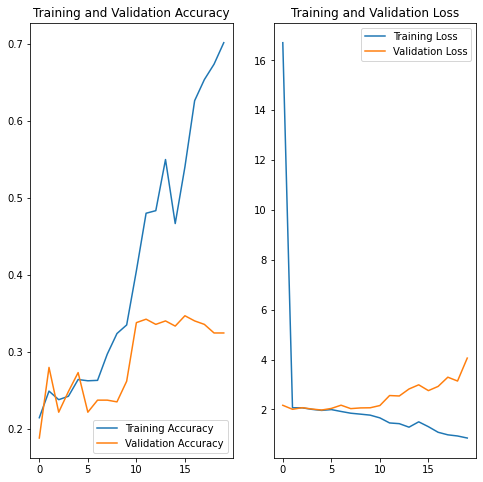

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observation: 

As we can see there is noticeable disconnect between the training accuracy and the validation accuracy. Also, in the loss value graph, we can see the training loss shows gradual decrease as epoch progresses. But the validation accuracy does not show any decrease at all. 
This is a clear sign of overfitting. 

##### Data Augmentation

We will carry out some random flip, rotation etc on the images, and then train the model once again to see if it takes care of overfitting issue. 

In [19]:
#Defining augmentation strategy

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2)
])

In [20]:
# Add the image to a batch
image = tf.expand_dims(image, 0)

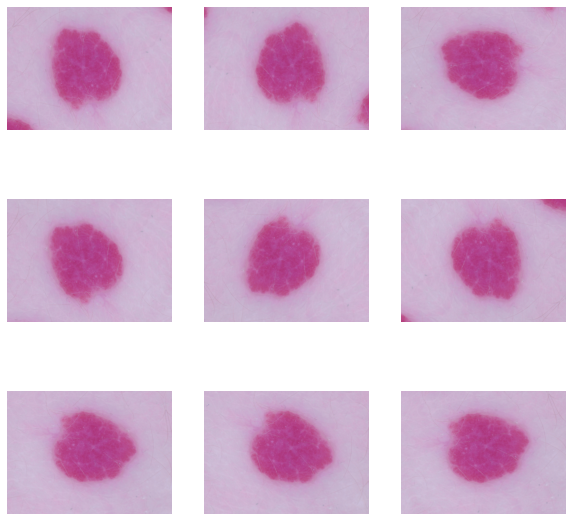

In [21]:
# Lets visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

In [22]:
#Applying augmentation strategy on the whole training dataset

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [23]:
#Checking the shape of the datset created
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


### Training the model

In [24]:
##Training the model with augmented images this time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 9s 155ms/step - loss: 1.8892 - accuracy: 0.3298 - val_loss: 1.8030 - val_accuracy: 0.3221
Epoch 2/20
56/56 [==============================] - 9s 152ms/step - loss: 1.6905 - accuracy: 0.3454 - val_loss: 2.1495 - val_accuracy: 0.2371
Epoch 3/20
56/56 [==============================] - 8s 150ms/step - loss: 1.7444 - accuracy: 0.3371 - val_loss: 1.7546 - val_accuracy: 0.3647
Epoch 4/20
56/56 [==============================] - 8s 151ms/step - loss: 1.6768 - accuracy: 0.3672 - val_loss: 2.0519 - val_accuracy: 0.2573
Epoch 5/20
56/56 [==============================] - 8s 150ms/step - loss: 1.7509 - accuracy: 0.3544 - val_loss: 1.7381 - val_accuracy: 0.3647
Epoch 6/20
56/56 [==============================] - 9s 154ms/step - loss: 1.6825 - accuracy: 0.3544 - val_loss: 1.6609 - val_accuracy: 0.4072
Epoch 7/20
56/56 [==============================] - 9s 152ms/step - loss: 1.7248 - accuracy: 0.3510 - val_loss: 1.6882 - val_accuracy: 0.4407
Epoch 

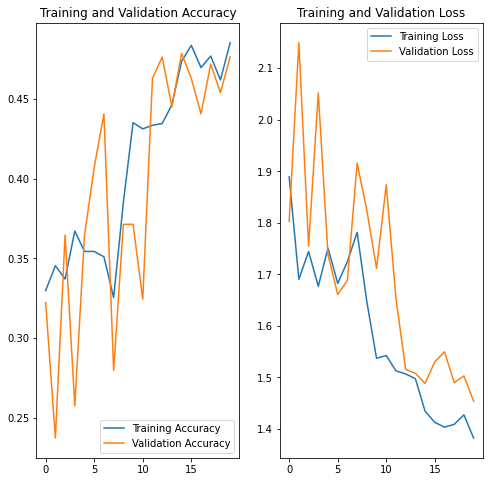

In [25]:
#visualizing the model performance

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observation:

The training and validation accuracy show similar pattern now, unlike the graph we had seen earlier. The loss function also show similar pattern in the graph. 
We can conclude that we have taken care of overfitting issue. 
Lets see how we can tune the model performance further. 

### Create the model, compile and train the model

In [26]:
## We will use Dropout layer to see if it improves the learning of the model any further

num_classes = 9

model = tf.keras.Sequential([
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes),
  layers.Activation('softmax')
])


### Compiling the model

In [27]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [28]:
## Training the model for 20 epochs

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


56/56 [==============================] - 9s 156ms/step - loss: 24.1492 - accuracy: 0.1791 - val_loss: 2.0532 - val_accuracy: 0.2864
Epoch 2/20
56/56 [==============================] - 9s 155ms/step - loss: 2.1114 - accuracy: 0.2165 - val_loss: 2.1019 - val_accuracy: 0.2125
Epoch 3/20
56/56 [==============================] - 9s 155ms/step - loss: 2.0506 - accuracy: 0.2126 - val_loss: 2.0823 - val_accuracy: 0.2103
Epoch 4/20
56/56 [==============================] - 9s 154ms/step - loss: 2.0168 - accuracy: 0.2193 - val_loss: 2.0382 - val_accuracy: 0.2058
Epoch 5/20
56/56 [==============================] - 9s 155ms/step - loss: 2.0200 - accuracy: 0.2065 - val_loss: 2.0266 - val_accuracy: 0.2058
Epoch 6/20
56/56 [==============================] - 9s 154ms/step - loss: 2.0114 - accuracy: 0.2093 - val_loss: 2.0349 - val_accuracy: 0.2192
Epoch 7/20
56/56 [==============================] - 9s 156ms/step - loss: 2.0222 - accuracy: 0.2104 - val_loss: 2.0236 - val_accuracy: 0.2036
Epoch 8/20
56/56

### Visualizing the results

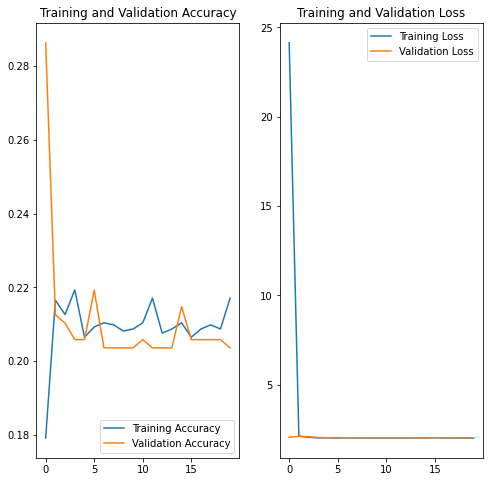

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observation: 
There did not seem to be any improvement in terms of accuracy with addition of dropout layer. Moreover, the validation loss does not show decreas at all. We will not be keeping the dropout layer. 

### Handling Class Imbalance

#### Lets find the distribution of classes in the training dataset.
#### Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [30]:
##Getting count of the files in each class in train data

count_list=[]
for classes in class_names:
    images_path = os.path.join(data_dir_train, classes, '*')
    image_count = len(list(glob.glob(images_path)))
    print("Class_name: " + classes)
    print("Count = " + str(image_count))
    count_list.append(image_count)

Class_name: actinic keratosis
Count = 114
Class_name: basal cell carcinoma
Count = 376
Class_name: dermatofibroma
Count = 95
Class_name: melanoma
Count = 438
Class_name: nevus
Count = 357
Class_name: pigmented benign keratosis
Count = 462
Class_name: seborrheic keratosis
Count = 77
Class_name: squamous cell carcinoma
Count = 181
Class_name: vascular lesion
Count = 139


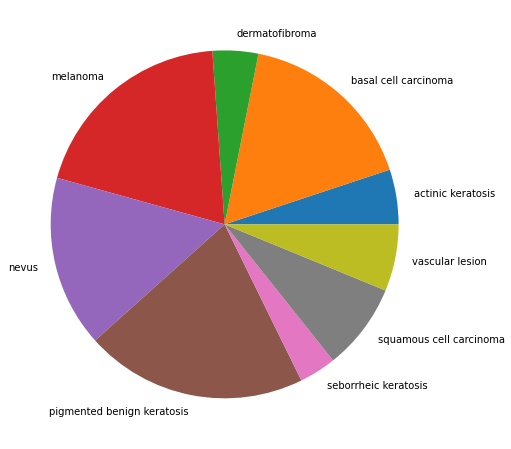

In [31]:
#Visualizing distribution of data over classes

plt.figure(figsize=(8, 8))

count_array = np.array(count_list)

plt.pie(count_array, labels = class_names)
plt.show()

### Observation:

#### - Which class has the least number of samples?
##### ---- "seborrheic keratosis" class has the least number of samples 
#### - Which classes dominate the data in terms proportionate number of samples?
##### ---- Classes"pigmented benign keratosis", "melanoma", "basal cell carcinoma", "nevus" dominate the data in terms proportionate number of samples

#### Lets rectify the class imbalance
#### We are going to use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [32]:
!pip install Augmentor 

In [33]:
#Defining the pipeline and adding 500 images to each class

path_to_training_dataset=r"gdrive/MyDrive/Project/Train"
import Augmentor
for i in class_names:
    path = os.path.join(path_to_training_dataset, i)
    p = Augmentor.Pipeline(path)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB3C20D94D0>:   0%|          | 1/500 [00:00<00:53,  9.28 Samples/s]

Initialised with 114 image(s) found.
Output directory set to gdrive/MyDrive/Project/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB3C20CAED0>: 100%|██████████| 500/500 [00:19<00:00, 25.90 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to gdrive/MyDrive/Project/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB3C20CAAD0>: 100%|██████████| 500/500 [00:18<00:00, 26.64 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to gdrive/MyDrive/Project/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB3C20CAE10>: 100%|██████████| 500/500 [00:20<00:00, 24.35 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to gdrive/MyDrive/Project/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FB42404F950>: 100%|██████████| 500/500 [01:26<00:00,  5.75 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to gdrive/MyDrive/Project/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=960x645 at 0x7FB3580D5DD0>: 100%|██████████| 500/500 [01:25<00:00,  5.82 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB358084F50>:   0%|          | 1/500 [00:00<01:08,  7.32 Samples/s]

Initialised with 462 image(s) found.
Output directory set to gdrive/MyDrive/Project/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB3C20CAFD0>: 100%|██████████| 500/500 [00:19<00:00, 25.60 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to gdrive/MyDrive/Project/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FB3C20C5190>: 100%|██████████| 500/500 [00:43<00:00, 11.53 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to gdrive/MyDrive/Project/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB424B26450>: 100%|██████████| 500/500 [00:19<00:00, 25.79 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to gdrive/MyDrive/Project/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB424C01050>: 100%|██████████| 500/500 [00:19<00:00, 25.03 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [34]:
#Count of files after adding new images

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [35]:
#file path for the new images
path_list = [x for x in data_dir_train.glob('*/output/*.jpg')]
path_list

[PosixPath('gdrive/MyDrive/Project/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026625.jpg_087b3039-2075-460c-a9b4-f4c654d48f9c.jpg'),
 PosixPath('gdrive/MyDrive/Project/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026457.jpg_847952ad-14d8-42d1-9cd4-bb735c420e36.jpg'),
 PosixPath('gdrive/MyDrive/Project/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026626.jpg_4347a8a9-d648-47da-97dd-a1c150be9f92.jpg'),
 PosixPath('gdrive/MyDrive/Project/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029900.jpg_37e23635-cc8c-4063-be92-ca2d0f0f9cac.jpg'),
 PosixPath('gdrive/MyDrive/Project/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027334.jpg_e29ae078-14d3-4730-a621-ba5cf11b4e50.jpg'),
 PosixPath('gdrive/MyDrive/Project/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032854.jpg_b1e7b14a-e283-4b3d-9bf1-d499b6f590ef.jpg'),
 PosixPath('gdrive/MyDrive/Project/Train/actinic keratosis/output/actinic ke

In [36]:
#creating labels list for the new images
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in data_dir_train.glob('*/output/*.jpg')]

In [37]:
#creating dictionary with images path and labels, for the new images
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [38]:
#We would need to create a dataframe for the original images as well, in order to merge the new images to it

#file path for original images
orig_path_list = [x for x in data_dir_train.glob('*/*.jpg')]

#creating labels list for the new images
label_list_orig = [os.path.basename(os.path.dirname(y)) for y in data_dir_train.glob('*/*.jpg')]

#creating dictionary for original images
dataframe_dict_orig = dict(zip(orig_path_list, label_list_orig))

In [39]:
original_df = pd.DataFrame(list(dataframe_dict_orig.items()),columns = ['Path','Label'])
original_df.head(20)

,Path,Label
0,gdrive/MyDrive/Project/Train/actinic keratosis...,actinic keratosis
1,gdrive/MyDrive/Project/Train/actinic keratosis...,actinic keratosis
2,gdrive/MyDrive/Project/Train/actinic keratosis...,actinic keratosis
3,gdrive/MyDrive/Project/Train/actinic keratosis...,actinic keratosis
4,gdrive/MyDrive/Project/Train/actinic keratosis...,actinic keratosis
5,gdrive/MyDrive/Project/Train/actinic keratosis...,actinic keratosis
6,gdrive/MyDrive/Project/Train/actinic keratosis...,actinic keratosis
7,gdrive/MyDrive/Project/Train/actinic keratosis...,actinic keratosis
8,gdrive/MyDrive/Project/Train/actinic keratosis...,actinic keratosis
9,gdrive/MyDrive/Project/Train/actinic keratosis...,actinic keratosis


In [40]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)
new_df.head(20)

,Path,Label
0,gdrive/MyDrive/Project/Train/actinic keratosis...,actinic keratosis
1,gdrive/MyDrive/Project/Train/actinic keratosis...,actinic keratosis
2,gdrive/MyDrive/Project/Train/actinic keratosis...,actinic keratosis
3,gdrive/MyDrive/Project/Train/actinic keratosis...,actinic keratosis
4,gdrive/MyDrive/Project/Train/actinic keratosis...,actinic keratosis
5,gdrive/MyDrive/Project/Train/actinic keratosis...,actinic keratosis
6,gdrive/MyDrive/Project/Train/actinic keratosis...,actinic keratosis
7,gdrive/MyDrive/Project/Train/actinic keratosis...,actinic keratosis
8,gdrive/MyDrive/Project/Train/actinic keratosis...,actinic keratosis
9,gdrive/MyDrive/Project/Train/actinic keratosis...,actinic keratosis


In [41]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Create, Compile and Train the model on the data created using Augmentor

In [70]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [71]:
data_dir_train=r"gdrive/MyDrive/Project/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [72]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [73]:
#defining normalization_layer
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

#applying normalization layer to the datset using map
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

# lets check the minimum and the maximum pixels values for the first image, if they are within `[0,1]`
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.00996746 0.9960785


In [74]:
#Checking the shape of the normalized datset
for image_batch, labels_batch in normalized_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [86]:
#Applying augmentation strategy on the whole training dataset

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

#### Compile the model

In [87]:
##Defining the arichitecture of the model

num_classes = 9

model = tf.keras.Sequential([
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes),
  layers.Activation('softmax')
])

In [88]:
### Lets choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

####  Train the model

In [89]:
#epochs = 30

epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


169/169 [==============================] - 72s 419ms/step - loss: 8.5599 - accuracy: 0.1480 - val_loss: 2.1893 - val_accuracy: 0.1411
Epoch 2/30
169/169 [==============================] - 71s 415ms/step - loss: 2.1782 - accuracy: 0.1432 - val_loss: 2.1870 - val_accuracy: 0.1418
Epoch 3/30
169/169 [==============================] - 71s 413ms/step - loss: 2.1816 - accuracy: 0.1482 - val_loss: 2.1594 - val_accuracy: 0.1722
Epoch 4/30
169/169 [==============================] - 70s 412ms/step - loss: 2.1496 - accuracy: 0.1641 - val_loss: 2.1919 - val_accuracy: 0.1403
Epoch 5/30
169/169 [==============================] - 71s 416ms/step - loss: 2.1755 - accuracy: 0.1454 - val_loss: 2.1839 - val_accuracy: 0.1440
Epoch 6/30
169/169 [==============================] - 71s 416ms/step - loss: 2.1792 - accuracy: 0.1384 - val_loss: 2.1896 - val_accuracy: 0.1403
Epoch 7/30
169/169 [==============================] - 71s 416ms/step - loss: 2.1977 - accuracy: 0.1408 - val_loss: 2.1866 - val_accuracy: 0.1

#### Visualize the model results

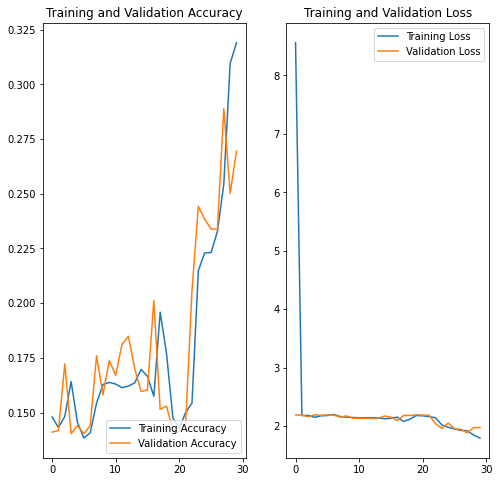

In [90]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observation:
The graph shows good trend of increase in both training and validation datasets. Also, the loss function of both training and validation data show gradual decrease and similar pattern. So, we are good with this learning. 

### Conclusion:

The basic model with the given data(as is) showed overfitting, as there was disconnect between training and validation accuracy.
Image augmentation with rotation and flip helped in improving the learning.
Class imbalance helped in overcoming the overfitting issue and improved the learning of the model. 

###### End of the notebook